# TinyML - Quantization-Aware Training (QAT)


#### Federal University of Rio Grande do Norte

#### Name: Thommas Kevin Sales Flores


## 0. Install the libraries listed in the requirements.txt file

In [1]:
#!pip install -r requirements.txt

## 1. Importing libraries

In [2]:
from sklearn.model_selection import train_test_split
import os
import time
import tensorflow as tf
import tensorflow_model_optimization as tfmot
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

from tensorflow.keras import layers, regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 2. Load Dataset

The "Vehicle Attributes and Emissions Dataset" contains comprehensive information on various vehicles manufactured in the year 2000. It includes details such as make, model, vehicle class, engine size, cylinder count, transmission type, and fuel type. Additionally, the dataset provides ranges for fuel consumption and CO2 emissions, offering insights into the environmental impact of each vehicle. The dataset encompasses a wide range of vehicle types, from compact to mid-size, and includes both conventional and high-performance models. With this information, analysts and researchers can study trends in vehicle characteristics, fuel efficiency, and emissions . This dataset serves as a valuable resource for understanding the automotive landscape and informing discussions on environmental sustainability and transportation policies.

link: https://www.kaggle.com/datasets/krupadharamshi/fuelconsumption/data

In [3]:
df = pd.read_csv('./data/FuelConsumption.csv')
df.head()

,Year,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,COEMISSIONS
0,2000,ACURA,1.6EL,COMPACT,1.6,4,A4,X,10.5,216
1,2000,ACURA,1.6EL,COMPACT,1.6,4,M5,X,9.8,205
2,2000,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Z,13.7,265
3,2000,ACURA,3.5RL,MID-SIZE,3.5,6,A4,Z,15.0,301
4,2000,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,X,11.4,230


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639 entries, 0 to 638
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              639 non-null    int64  
 1   MAKE              639 non-null    object 
 2   MODEL             639 non-null    object 
 3   VEHICLE CLASS     639 non-null    object 
 4   ENGINE SIZE       639 non-null    float64
 5   CYLINDERS         639 non-null    int64  
 6   TRANSMISSION      639 non-null    object 
 7   FUEL              639 non-null    object 
 8   FUEL CONSUMPTION  639 non-null    float64
 9   COEMISSIONS       639 non-null    int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 50.0+ KB


In [5]:
df.describe()

,Year,ENGINE SIZE,CYLINDERS,FUEL CONSUMPTION,COEMISSIONS
count,639.0,639.000000,639.000000,639.000000,639.000000
mean,2000.0,3.265728,5.805947,14.713615,296.809077
std,0.0,1.231012,1.625588,3.307044,65.504178
min,2000.0,1.000000,3.000000,4.900000,104.000000
25%,2000.0,2.200000,4.000000,12.500000,253.000000
50%,2000.0,3.000000,6.000000,14.400000,288.000000
75%,2000.0,4.300000,6.000000,16.600000,343.000000
max,2000.0,8.000000,12.000000,30.200000,582.000000


## 3. Clean Data

In [6]:
# 1. Removing rows with missing values
df.dropna(inplace=True)

In [7]:
# 2. Removing duplicates if any
df.drop_duplicates(inplace=True)

In [8]:
# Display the dataframe after cleaning
df.describe()

,Year,ENGINE SIZE,CYLINDERS,FUEL CONSUMPTION,COEMISSIONS
count,638.0,638.000000,638.000000,638.000000,638.000000
mean,2000.0,3.264577,5.802508,14.705956,296.642633
std,0.0,1.231634,1.624535,3.303962,65.420203
min,2000.0,1.000000,3.000000,4.900000,104.000000
25%,2000.0,2.200000,4.000000,12.500000,253.000000
50%,2000.0,3.000000,6.000000,14.400000,288.000000
75%,2000.0,4.300000,6.000000,16.600000,343.000000
max,2000.0,8.000000,12.000000,30.200000,582.000000


## 4. Exploratory Data Analysis

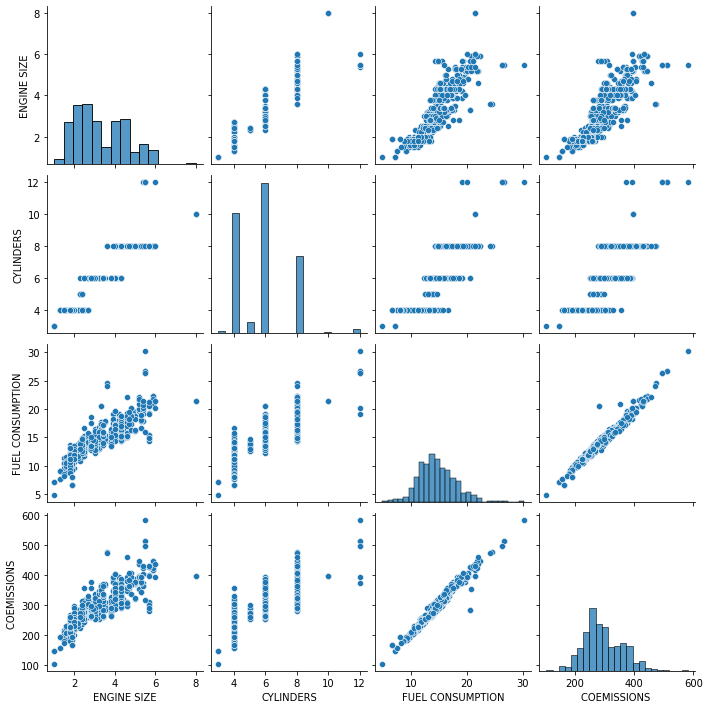

In [9]:
sns.pairplot(df[['ENGINE SIZE','CYLINDERS','FUEL CONSUMPTION','COEMISSIONS ']])
plt.savefig('.\\figures\\pairplot.png', dpi=300, bbox_inches='tight')

In [10]:
corr = df[['ENGINE SIZE','CYLINDERS','FUEL CONSUMPTION','COEMISSIONS ']].corr('spearman')

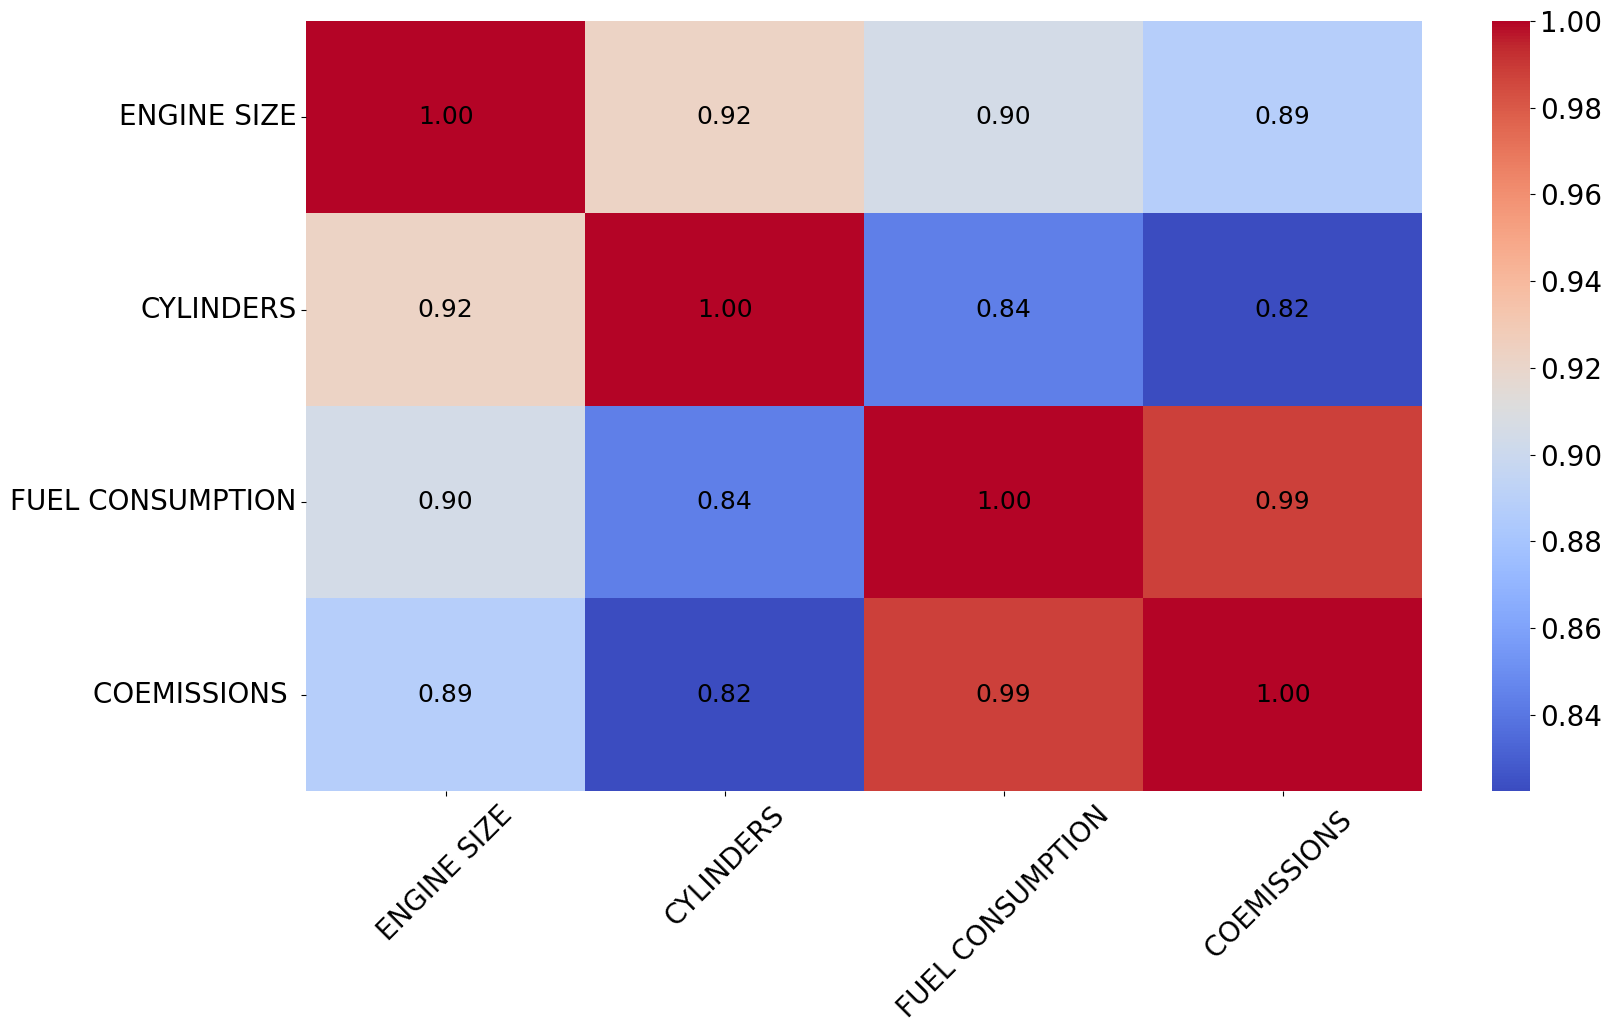

In [11]:
# Adjusting the size of the figure
plt.figure(figsize=(18,10))
# Your existing code for generating the heatmap
heatmap = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm')
# Adding values to the heatmap
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        plt.text(j + 0.5, i + 0.5, f"{corr.iloc[i, j]:.2f}", ha='center', va='center', color='black', fontsize=18)

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20, rotation=0)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)

plt.savefig('.\\figures\\heatmap.png', dpi=300, bbox_inches='tight')

# Display the heatmap
plt.show()

## 5. Splitting the data

In [12]:
X=df[['ENGINE SIZE','CYLINDERS', 'COEMISSIONS ']]
y=df[['FUEL CONSUMPTION']]

In [13]:
# Normalización min-max
scaler = MinMaxScaler()
normalized_X = scaler.fit_transform(X)

In [14]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.3, random_state=42)

## 6. Define the model

In [15]:
# Define the model
model = tf.keras.Sequential([
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dense(1, activation='linear')
])


## 7. Compile the model

In [16]:
# Compile the model
model.compile(optimizer='Adam', loss='mse', metrics=['mse'])

## 8. Training model

In [17]:
history = model.fit(X_train, y_train,
                      batch_size=64,
                      epochs=300,
                      validation_split=0.1,
                      verbose=1)

Epoch 1/300


7/7 [==============================] - 1s 37ms/step - loss: 219.8664 - mse: 219.8625 - val_loss: 222.0368 - val_mse: 222.0330
Epoch 2/300
7/7 [==============================] - 0s 6ms/step - loss: 218.2414 - mse: 218.2377 - val_loss: 220.1676 - val_mse: 220.1640
Epoch 3/300
7/7 [==============================] - 0s 6ms/step - loss: 216.2397 - mse: 216.2360 - val_loss: 217.9318 - val_mse: 217.9282
Epoch 4/300
7/7 [==============================] - 0s 6ms/step - loss: 213.9257 - mse: 213.9221 - val_loss: 215.4089 - val_mse: 215.4054
Epoch 5/300
7/7 [==============================] - 0s 6ms/step - loss: 211.2756 - mse: 211.2721 - val_loss: 212.5493 - val_mse: 212.5459
Epoch 6/300
7/7 [==============================] - 0s 6ms/step - loss: 208.2898 - mse: 208.2865 - val_loss: 209.2278 - val_mse: 209.2244
Epoch 7/300
7/7 [==============================] - 0s 6ms/step - loss: 204.8110 - mse: 204.8076 - val_loss: 205.3337 - val_mse: 205.3304
Epoch 8/300
7/7 [=====================

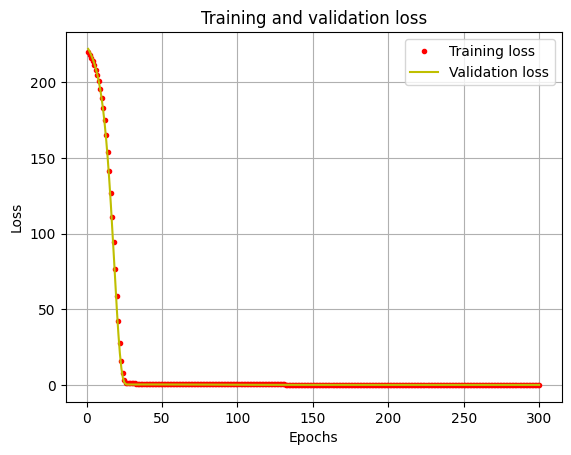

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r.', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.savefig('.\\figures\\history_traing.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
model.save('.\models\model.keras')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                128       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 801 (3.13 KB)
Trainable params: 801 (3.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 9. Retrain Quantized Model

In [21]:
quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
                        loss='mse',
                        metrics=['mse'])

In [22]:
X_train_subset = X_train
y_train_subset = y_train

history_q =  q_aware_model.fit(X_train_subset, y_train_subset,
                  batch_size=64, epochs=300, validation_split=0.3)

Epoch 1/300
5/5 [==============================] - 1s 56ms/step - loss: 83.1453 - mse: 83.1408 - val_loss: 82.7351 - val_mse: 82.7306
Epoch 2/300
5/5 [==============================] - 0s 11ms/step - loss: 82.3678 - mse: 82.3633 - val_loss: 81.8010 - val_mse: 81.7966
Epoch 3/300
5/5 [==============================] - 0s 10ms/step - loss: 81.5952 - mse: 81.5908 - val_loss: 80.8690 - val_mse: 80.8646
Epoch 4/300
5/5 [==============================] - 0s 10ms/step - loss: 80.8217 - mse: 80.8174 - val_loss: 79.9393 - val_mse: 79.9351
Epoch 5/300
5/5 [==============================] - 0s 10ms/step - loss: 80.1927 - mse: 80.1885 - val_loss: 79.8035 - val_mse: 79.7993
Epoch 6/300
5/5 [==============================] - 0s 13ms/step - loss: 79.2627 - mse: 79.2586 - val_loss: 78.8795 - val_mse: 78.8755
Epoch 7/300
5/5 [==============================] - 0s 11ms/step - loss: 78.4947 - mse: 78.4907 - val_loss: 77.9630 - val_mse: 77.9590
Epoch 8/300
5/5 [==============================] - 0s 9ms/step

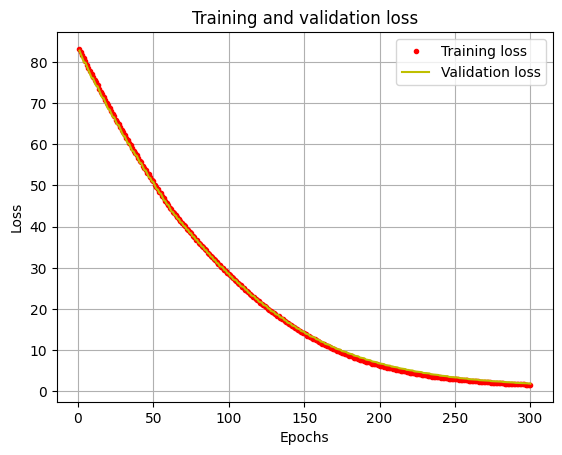

In [23]:
loss = history_q.history['loss']
val_loss = history_q.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r.', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.savefig('.\\figures\\history_traing_q.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Model Evaluation

In [24]:
_, baseline_model_MSE = model.evaluate(
    X_test, y_test, verbose=0)

_, q_aware_model_MSE = q_aware_model.evaluate(
   X_test, y_test, verbose=0)

print('Without test MSE:', baseline_model_MSE)
print('Quant test MSE:', q_aware_model_MSE)

Without test MSE: 0.2929968535900116
Quant test MSE: 3.560596466064453


In [25]:
def plot_histogram(error,name):

    error_mean = np.mean(error)
    error_std = np.std(error)
    error_max = np.max(error)
    error_min = np.min(error)

    plt.figure(figsize=(10, 6))
    sns.distplot(error, hist=True, kde=True, bins=20, color='blue', hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 2})
    plt.xlabel('Error', fontsize=13)
    plt.ylabel('Density', fontsize=13)
    plt.title('Error Distribution with Density Curve', fontsize=15)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.grid(True)


    plt.axvline(x=error_mean, color='red', linestyle='--', label='Mean')
    plt.axvline(x=error_mean - error_std, color='green', linestyle='--', label='Mean - Std')
    plt.axvline(x=error_max, color='purple', linestyle='--', label='Max')
    plt.axvline(x=error_min, color='orange', linestyle='--', label='Min')

    plt.text(error_mean, plt.ylim()[1]*0.9, f'Mean: {error_mean:.2f}', color='red', fontsize=12, ha='center')
    plt.text(error_mean - error_std, plt.ylim()[1]*0.85, f'Std: {error_std:.2f}', color='green', fontsize=12, ha='center')
    plt.text(error_max, plt.ylim()[1]*0.8, f'Max: {error_max:.2f}', color='purple', fontsize=12, ha='center')
    plt.text(error_min, plt.ylim()[1]*0.75, f'Min: {error_min:.2f}', color='orange', fontsize=12, ha='center')
    plt.savefig(f'.\\figures\\hist_{name}.png', dpi=300, bbox_inches='tight')
    plt.grid(True)
    plt.show()

### 10.1 Training Data

#### 10.1.1 Not Quantized

In [26]:
y_train_pred = model.predict(X_train)


14/14 [==============================] - 0s 1ms/step


In [27]:
error_training = y_train_pred - y_train.values

In [28]:
mae = mean_absolute_error(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_train_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)

Mean Absolute Error (MAE): 0.3331298577945862
Mean Squared Error (MSE): 0.3451520788967117
Root Mean Squared Error (RMSE): 0.5874964501141362
R-squared (R²): 0.9642734013146145


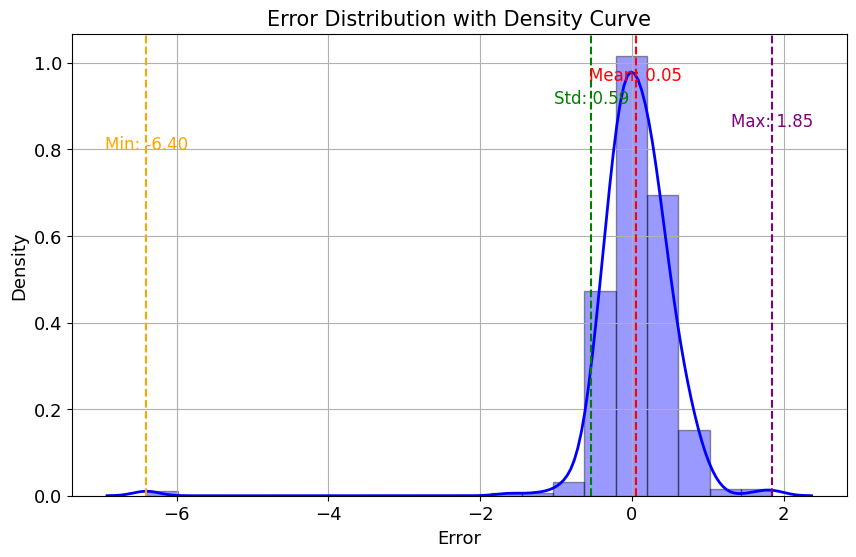

In [29]:
plot_histogram(error_training, 'training')

#### 10.1.2 Quantization Aware Training

In [30]:
y_train_pred_q = q_aware_model.predict(X_train)

14/14 [==============================] - 0s 1ms/step


In [31]:
error_training_q = y_train_pred_q - y_train.values

In [32]:
mae = mean_absolute_error(y_train, y_train_pred_q)
mse = mean_squared_error(y_train, y_train_pred_q)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_train_pred_q)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)

Mean Absolute Error (MAE): 0.6291654479877831
Mean Squared Error (MSE): 1.6614236314265158
Root Mean Squared Error (RMSE): 1.2889622304111614
R-squared (R²): 0.8280264875815686


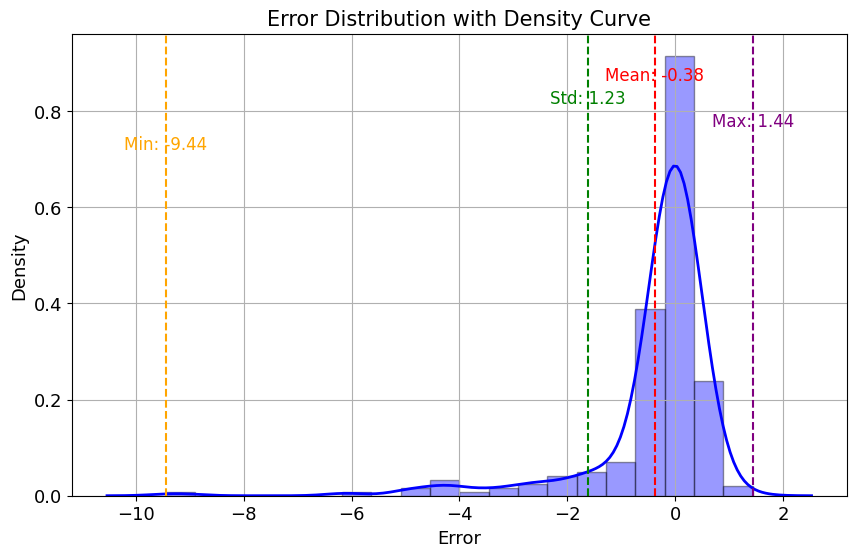

In [33]:
plot_histogram(error_training_q, 'training_q')


### 10.2 Test Data

#### 10.1.1 Not Quantized

In [34]:
y_test_pred = model.predict(X_test)


6/6 [==============================] - 0s 1ms/step


In [35]:
error_testing = y_test_pred - y_test.values

In [36]:
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)

Mean Absolute Error (MAE): 0.36716325183709464
Mean Squared Error (MSE): 0.292996862282487
Root Mean Squared Error (RMSE): 0.5412918457565078
R-squared (R²): 0.9785794090106756


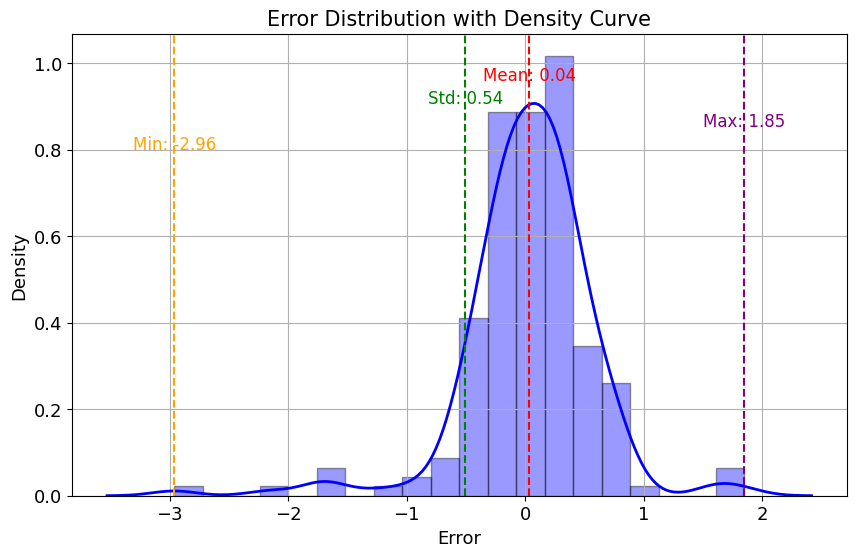

In [37]:
plot_histogram(error_testing, 'testing')

#### 10.1.2 Quantization Aware Training

In [38]:
y_test_pred_q = q_aware_model.predict(X_test)

6/6 [==============================] - 0s 2ms/step


In [39]:
error_testing_q = y_test_pred_q - y_test.values

In [40]:
mae = mean_absolute_error(y_test, y_test_pred_q)
mse = mean_squared_error(y_test, y_test_pred_q)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_pred_q)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)

Mean Absolute Error (MAE): 0.8663584515452385
Mean Squared Error (MSE): 3.5605961483215736
Root Mean Squared Error (RMSE): 1.8869541987874463
R-squared (R²): 0.739689793340429


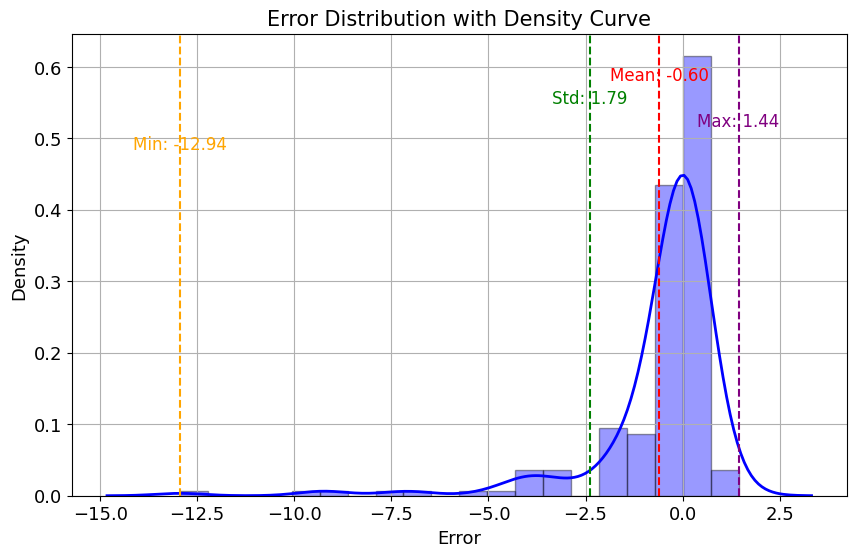

In [41]:
plot_histogram(error_testing_q, 'testing_q')


## 11. Obtaining the model to be implemented in the microcontroller

In [42]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifdef __has_attribute\n'
  c_str += '#define HAVE_ATTRIBUTE(x) __has_attribute(x)\n'
  c_str += '#else\n'
  c_str += '#define HAVE_ATTRIBUTE(x) 0\n'
  c_str += '#endif\n'
  c_str += '#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))\n'
  c_str += '#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))\n'
  c_str += '#else\n'
  c_str += '#define DATA_ALIGN_ATTRIBUTE\n'
  c_str += '#endif\n\n'

  # Declare C variable
  c_str += 'const unsigned char ' + var_name + '[]  DATA_ALIGN_ATTRIBUTE = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += 'const int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  return c_str

### 11.1 Convert o model to Float32 and Int8

In [43]:
def representative_dataset():
    for i in range(len(X_train)):
        input_data = np.array([X_train[i]], dtype=np.float32)
        yield [input_data]



def converter_quantization_model(model, model_name):

    # Convert o model to float32
    converter_float32 = tf.lite.TFLiteConverter.from_keras_model(model)
    converter_float32.optimizations = [tf.lite.Optimize.DEFAULT]
    converter_float32.target_spec.supported_types = [tf.float32]
    converter_float32._experimental_lower_tensor_list_ops = False
    converter_float32.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
    converter_float32.representative_dataset = representative_dataset
    tflite_model_float32 = converter_float32.convert()
    print(tflite_model_float32)
    with open(model_name+'_quant_float32' + '.h', 'w') as file:
        file.write(hex_to_c_array(tflite_model_float32, model_name+'_quant_float32'))
    with open(model_name+'_quant_float32.tflite', 'wb') as f:
        f.write(tflite_model_float32)
    size_model_tflite_float32 = os.path.getsize(model_name+'_quant_float32.tflite')
    print(model_name+f'_quant_float32.tflite: {size_model_tflite_float32} Bytes')


    # Convert o model to Int8
    converter_int8 = tf.lite.TFLiteConverter.from_keras_model(model)
    converter_int8.optimizations = [tf.lite.Optimize.DEFAULT]
    converter_int8.target_spec.supported_types = [tf.int8]
    #converter_int8._experimental_lower_tensor_list_ops = False
    converter_int8.representative_dataset = representative_dataset
    converter_int8.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
        tf.lite.OpsSet.SELECT_TF_OPS,
    ]
    converter_int8.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
    converter_int8.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter_int8.experimental_new_converter = True
    converter_int8.experimental_new_quantizer = True
    converter_int8.experimental_new_calibrator = True
    tflite_model_int8 = converter_int8.convert()
    with open(model_name+'_quant_int8' + '.h', 'w') as file:
        file.write(hex_to_c_array(tflite_model_int8, model_name+'_quant_int8'))
    with open(model_name+'_quant_int8.tflite', 'wb') as f:
        f.write(tflite_model_int8)
    size_model_tflite_int8 = os.path.getsize(model_name+'_quant_int8.tflite')
    print(model_name+f'_quant_int8.tflite: {size_model_tflite_int8} Bytes')

    return None

### 11.1.1 Not Quantized

In [44]:
model_name='.\models\model'
converter_quantization_model(model, model_name)

INFO:tensorflow:Assets written to: C:\Users\Thommas\AppData\Local\Temp\tmpn1e0fkkc\assets


INFO:tensorflow:Assets written to: C:\Users\Thommas\AppData\Local\Temp\tmpn1e0fkkc\assets


b'\x1c\x00\x00\x00TFL3\x14\x00 \x00\x1c\x00\x18\x00\x14\x00\x10\x00\x0c\x00\x00\x00\x08\x00\x04\x00\x14\x00\x00\x00\x1c\x00\x00\x00\x90\x00\x00\x00\xe8\x00\x00\x00\xa8\x0e\x00\x00\xb8\x0e\x00\x00\x1c\x15\x00\x00\x03\x00\x00\x00\x01\x00\x00\x00\x10\x00\x00\x00\x00\x00\n\x00\x10\x00\x0c\x00\x08\x00\x04\x00\n\x00\x00\x00\x0c\x00\x00\x00\x1c\x00\x00\x008\x00\x00\x00\x0f\x00\x00\x00serving_default\x00\x01\x00\x00\x00\x04\x00\x00\x00\x98\xff\xff\xff\x0c\x00\x00\x00\x04\x00\x00\x00\x07\x00\x00\x00dense_3\x00\x01\x00\x00\x00\x04\x00\x00\x00"\xf2\xff\xff\x04\x00\x00\x00\x0b\x00\x00\x00dense_input\x00\x02\x00\x00\x004\x00\x00\x00\x04\x00\x00\x00\xdc\xff\xff\xff\x0f\x00\x00\x00\x04\x00\x00\x00\x13\x00\x00\x00CONVERSION_METADATA\x00\x08\x00\x0c\x00\x08\x00\x04\x00\x08\x00\x00\x00\x0e\x00\x00\x00\x04\x00\x00\x00\x13\x00\x00\x00min_runtime_version\x00\x10\x00\x00\x00\xbc\r\x00\x00\xb4\r\x00\x00d\r\x00\x00,\r\x00\x00\x18\r\x00\x00\x88\x0c\x00\x00\xf8\n\x00\x00\xe8\x02\x00\x00\xd8\x00\x00\x00\xa8\x00\

INFO:tensorflow:Assets written to: C:\Users\Thommas\AppData\Local\Temp\tmpkegc22bq\assets


.\models\model_quant_int8.tflite: 4088 Bytes


### 11.1.2 Quantization Aware Training

In [45]:
model_name='.\models\q_aware_model'
converter_quantization_model(q_aware_model, model_name)

INFO:tensorflow:Assets written to: C:\Users\Thommas\AppData\Local\Temp\tmpd45j0ypx\assets


INFO:tensorflow:Assets written to: C:\Users\Thommas\AppData\Local\Temp\tmpd45j0ypx\assets


b' \x00\x00\x00TFL3\x00\x00\x00\x00\x14\x00 \x00\x1c\x00\x18\x00\x14\x00\x10\x00\x0c\x00\x00\x00\x08\x00\x04\x00\x14\x00\x00\x00\x1c\x00\x00\x00\x8c\x00\x00\x00\xe4\x00\x00\x00\x00\x06\x00\x00\x10\x06\x00\x00\xc4\x11\x00\x00\x03\x00\x00\x00\x01\x00\x00\x00\x04\x00\x00\x00\xaa\xf9\xff\xff\x0c\x00\x00\x00\x1c\x00\x00\x00@\x00\x00\x00\x0f\x00\x00\x00serving_default\x00\x01\x00\x00\x00\x04\x00\x00\x00\x90\xff\xff\xff\x0e\x00\x00\x00\x04\x00\x00\x00\r\x00\x00\x00quant_dense_3\x00\x00\x00\x01\x00\x00\x00\x04\x00\x00\x00\x06\xfb\xff\xff\x04\x00\x00\x00\x0b\x00\x00\x00dense_input\x00\x02\x00\x00\x004\x00\x00\x00\x04\x00\x00\x00\xdc\xff\xff\xff\x11\x00\x00\x00\x04\x00\x00\x00\x13\x00\x00\x00CONVERSION_METADATA\x00\x08\x00\x0c\x00\x08\x00\x04\x00\x08\x00\x00\x00\x10\x00\x00\x00\x04\x00\x00\x00\x13\x00\x00\x00min_runtime_version\x00\x12\x00\x00\x00\x18\x05\x00\x00\x10\x05\x00\x00\x80\x04\x00\x00d\x04\x00\x004\x04\x00\x00\xe4\x03\x00\x00\xdc\x03\x00\x00l\x03\x00\x00d\x03\x00\x00T\x01\x00\x00L\x01\

INFO:tensorflow:Assets written to: C:\Users\Thommas\AppData\Local\Temp\tmpxa2t3vq5\assets


.\models\q_aware_model_quant_int8.tflite: 4688 Bytes


## 12. Converted Model Evaluation

In [46]:
def evaluate_quantization(model_path, X_test, y_test, quantization_type):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Avaliar o modelo quantizado
    input_index = interpreter.get_input_details()[0]['index']
    output_index = interpreter.get_output_details()[0]['index']
    predictions = []
    processing_times = []

    X_test = np.array(X_test, dtype=np.float32)
    
    for X in X_test:
        interpreter.set_tensor(input_index, [X])
        
        start_time = time.time()
        interpreter.invoke()
        end_time = time.time()
        processing_time = end_time - start_time
        processing_times.append(processing_time)
        output = interpreter.get_tensor(output_index)
        predictions.append(output[0])

    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
   
    # Calcular a média e o desvio padrão das diferenças
    result = { "MSE":mse,
                "MAE": mae,
                "R2-Score": r2,
                "Process time": np.mean(processing_times)
            }

    return result

### 12.1 Not Quantized

In [47]:
model_name = '.\models\model'

In [48]:
eval_quant_float32 = evaluate_quantization(model_name + '_quant_float32.tflite', X_test, y_test, 'float32')
eval_quant_float32


{'MSE': 0.2929970215370584,
 'MAE': 0.3671633064746857,
 'R2-Score': 0.9785793973677965,
 'Process time': 1.041466991106669e-05}

In [49]:
eval_quant_int8 = evaluate_quantization(model_name + '_quant_int8.tflite', X_test, y_test, 'int8')
eval_quant_int8 

{'MSE': 0.3997019889302411,
 'MAE': 0.3849833682179451,
 'R2-Score': 0.9707783463761486,
 'Process time': 1.0417153437932333e-05}

### 12.2 Quantization Aware Training

In [50]:
model_q_name = '.\models\q_aware_model'

In [51]:
eval_quant_float32 = evaluate_quantization(model_q_name + '_quant_float32.tflite', X_test, y_test, 'float32')
eval_quant_float32


{'MSE': 3.5605984581232364,
 'MAE': 0.8663586229085922,
 'R2-Score': 0.7396896244740585,
 'Process time': 1.0407219330469767e-05}

In [52]:
eval_quant_int8 = evaluate_quantization(model_q_name + '_quant_int8.tflite', X_test, y_test, 'int8')
eval_quant_int8 

{'MSE': 3.5605984581232364,
 'MAE': 0.8663586229085922,
 'R2-Score': 0.7396896244740585,
 'Process time': 5.220373471577962e-06}